In [81]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import joblib
from tqdm import tqdm
import pims
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

show_verb = True
save_verb = False
anim_show_verb = False

In [36]:
data = pims.open('../data/video/movie.mp4')
rawTrajs = pd.read_csv("../data/csv/Processed_data2.csv")
red_particle_idx = 17
rawTrajs.loc[rawTrajs.particle!=red_particle_idx, ["color"]] = "#00007F"
rawTrajs.loc[rawTrajs.particle==red_particle_idx, ["color"]] = "#FF0000"
colors = rawTrajs.loc[rawTrajs.frame==0, 'color'].values

nDrops = len(rawTrajs.loc[rawTrajs.frame==0])
nFrames = max(rawTrajs.frame) + 1
print(f"nDrops:{nDrops}")
print(f"nFrames:{nFrames} --> {nFrames/10:.2f} s")

# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window+1, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")

# step 10 with a 10 fps video --> 1 s  
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}

18:43:54 [WARNING] deprecated pixel format used, make sure you did set range correctly


nDrops:50
nFrames:32000 --> 3200.00 s
window of 320.0 s, stride of 10.0 s
number of steps: 289


In [33]:
# raw trajectories
blueTrajs = []
redTraj = []
for i in range(0, nDrops):
    if i == red_particle_idx:
        p = rawTrajs.loc[rawTrajs.particle == i, ["x","y"]]
        redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
    else:
        p = rawTrajs.loc[rawTrajs.particle == i, ["x","y"]]
        blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))

# Trajectory Smoothing

Smoothing of the trajectory using a Savgol Filter in order to drop the noise due to the tracking procedure

In [59]:
pxDimension = 1 # has to be fixed 
fps = 10 # fps of the video
maxLagtime = 1000 # maximum lagtime to be considered

# Power Law fit
def powerLawFit(funct, fit, powerlawExponents):
    for i in range(nDrops):
        powerlawFit = tp.utils.fit_powerlaw(funct[i], plot = False) 
        powerlawExponents[i] = powerlawFit.n.values 
        fit[i] = powerlawFit.A.values * np.array(funct.index)**powerlawExponents[i] 
    return fit, powerlawExponents

In [37]:
def get_smooth_trajetories(windLen, orderofPoly):
    smoothTrajs = rawTrajs.copy()
    for i in range(nDrops):
        smoothTrajs.loc[smoothTrajs.particle == i, "x"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].x.values, windLen, orderofPoly)
        smoothTrajs.loc[smoothTrajs.particle == i, "y"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].y.values, windLen, orderofPoly)
    return smoothTrajs

In [76]:
windList = np.linspace(3, 30, 8, dtype=int)

In [77]:
im = tp.imsd(rawTrajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
fit, powerlawExponents = powerLawFit(im, np.zeros((nDrops, maxLagtime)), np.zeros(nDrops))

v_blue = ys.speed_ensemble(blueTrajs, step=10)
v_red = ys.speed_ensemble(redTraj, step=10)

theta_blue = ys.turning_angles_ensemble(blueTrajs, centered = True)
theta_red = ys.turning_angles_ensemble(redTraj, centered = True)

vacf_mean_blue, vacf_std_blue = ys.vacf(blueTrajs, time_avg=True, lag=maxLagtime)
vacf_mean_red, vacf_std_red = ys.vacf(redTraj, time_avg=True, lag=maxLagtime)

In [78]:
diff_pw = []
diff_pw2 = []
diff_turn_blue = []
diff_turn_red = []
diff_v_blue = []
diff_v_red = []
diff_vacf_blue = []
diff_vacf_red = []

for j in tqdm(range(len(windList))):
    smoothTrajs = get_smooth_trajetories(windList[j], 2)

    im_smooth = tp.imsd(smoothTrajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
    fit_smooth, powerlawExponents_smooth = powerLawFit(im_smooth, np.zeros((nDrops, maxLagtime)), np.zeros(nDrops))
    diff_pw.append(powerlawExponents - powerlawExponents_smooth)

    fit_smooth, powerlawExponents_smooth = powerLawFit(im_smooth.iloc[10:], np.zeros((nDrops, maxLagtime-10)), np.zeros(nDrops))
    diff_pw2.append(powerlawExponents - powerlawExponents_smooth)
    
    blueTrajs_smooth = []
    redTraj_smooth = []
    for i in range(0, nDrops):
        if i == red_particle_idx:
            p = smoothTrajs.loc[smoothTrajs.particle == i, ["x","y"]]
            redTraj_smooth.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        else:
            p = smoothTrajs.loc[smoothTrajs.particle == i, ["x","y"]]
            blueTrajs_smooth.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))

    v_blue_smooth = ys.speed_ensemble(blueTrajs_smooth, step=10)
    v_red_smooth = ys.speed_ensemble(redTraj_smooth, step=10)
    diff_v_blue.append(v_blue - v_blue_smooth)
    diff_v_red.append(v_red - v_red_smooth)

    theta_blue_smooth = ys.turning_angles_ensemble(blueTrajs_smooth, centered = True)
    theta_red_smooth = ys.turning_angles_ensemble(redTraj_smooth, centered = True)
    diff_turn_blue.append(theta_blue - theta_blue_smooth)
    diff_turn_red.append(theta_red - theta_red_smooth)

    vacf_mean_blue_smooth, vacf_std_blue_smooth = ys.vacf(blueTrajs_smooth, time_avg=True, lag=maxLagtime)
    vacf_mean_red_smooth, vacf_std_red_smooth = ys.vacf(redTraj_smooth, time_avg=True, lag=maxLagtime)
    
    diff_vacf_blue.append(vacf_mean_blue - vacf_mean_blue_smooth)
    diff_vacf_red.append(vacf_mean_red - vacf_mean_red_smooth)
    

100%|██████████| 8/8 [04:06<00:00, 30.87s/it]


In [85]:
def boltzmann(v, sigma):
    return v/(sigma**2) * np.exp(-v**2/(2*sigma**2))

In [87]:
bin_heights, bin_borders, _ = plt.hist(v_blue_smooth, bins='auto', label='histogram')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(boltzmann, bin_centers, bin_heights, p0 = [1.])
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, boltzmann(x_interval_for_fit, *popt), label='fit')
plt.legend()

NameError: name 'sigma' is not defined

(0, 2.6661706171232353)


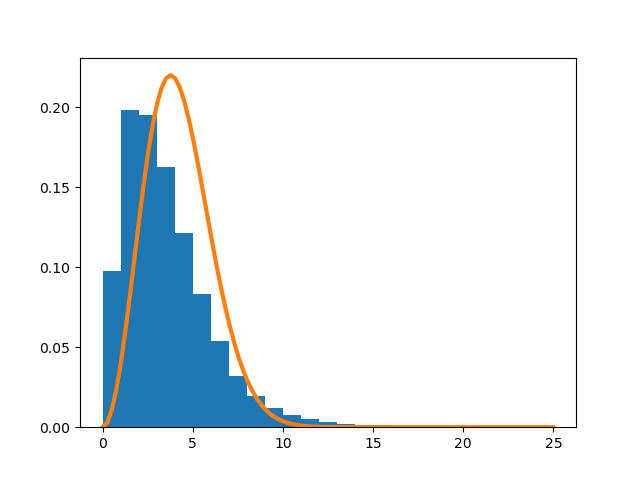

In [94]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

HIST_BINS1 = np.arange(0, 20, 1)
HIST_BINS2 = np.arange(0, 40, .4)

maxwell = stats.maxwell
params = maxwell.fit(v_blue_smooth, floc=0)
print(params)
# (0, 4.9808603062591041)

fig, ax = plt.subplots(1, 1)
ax.hist(v_blue_smooth, bins=HIST_BINS1, density=True)
x = np.linspace(0, 25, 100)
ax.plot(x, maxwell.pdf(x, *params), lw=3)
plt.show()

/var/folders/8x/m08xmk_178vd007wy7lbx80w0000gn/T/ipykernel_13254/1567570119.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(10, 10))


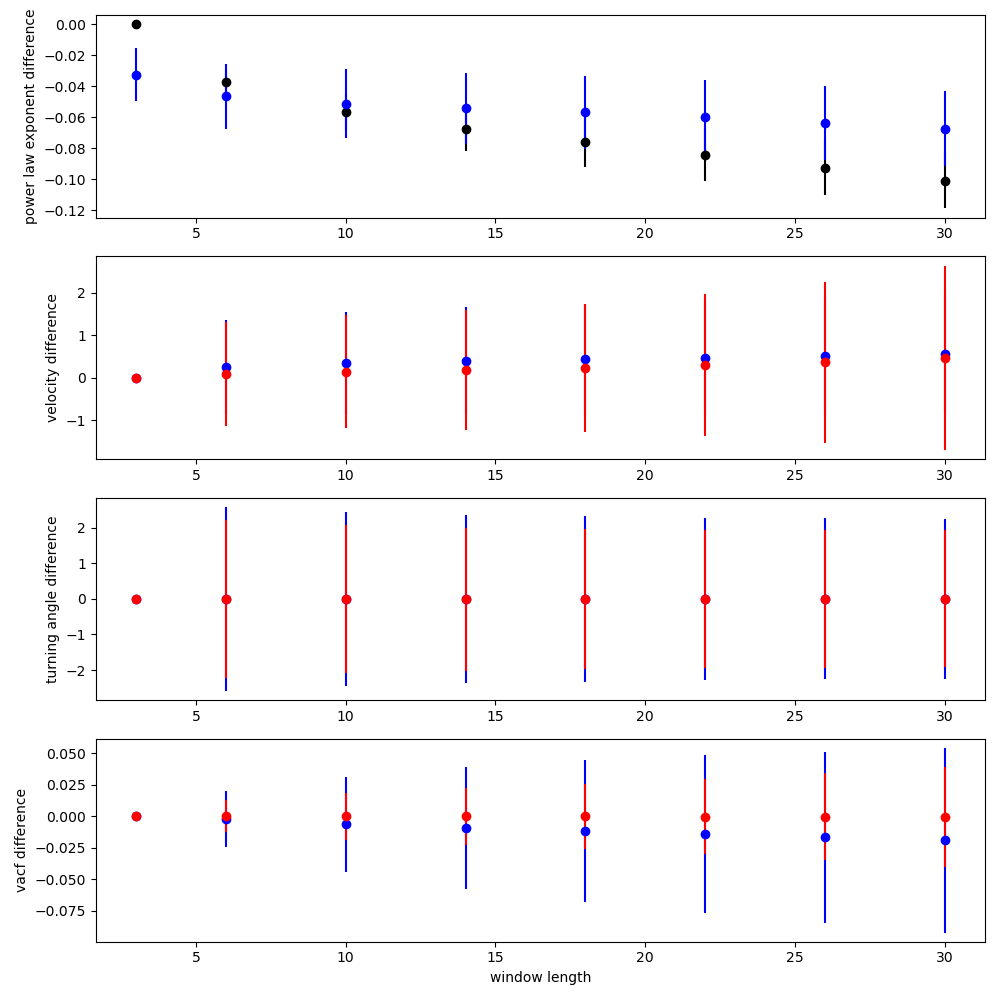

In [79]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(10, 10))
ax.errorbar(windList, np.mean(diff_pw, axis=1), yerr=np.std(diff_pw, axis=1), fmt='o', color='black')
ax.errorbar(windList, np.mean(diff_pw2, axis=1), yerr=np.std(diff_pw2, axis=1), fmt='o', color='blue')
ax.set_ylabel("power law exponent difference")

ax1.errorbar(windList, np.mean(diff_v_blue, axis=1), yerr=np.std(diff_v_blue, axis=1), fmt='o', color='blue')
ax1.errorbar(windList, np.mean(diff_v_red, axis=1), yerr=np.std(diff_v_red, axis=1), fmt='o', color='red')
ax1.set_ylabel("velocity difference")

ax2.errorbar(windList, np.mean(diff_turn_blue, axis=1), yerr=np.std(diff_turn_blue, axis=1), fmt='o', color='blue')
ax2.errorbar(windList, np.mean(diff_turn_red, axis=1), yerr=np.std(diff_turn_red, axis=1), fmt='o', color='red')
ax2.set_ylabel("turning angle difference")

ax3.errorbar(windList, np.mean(diff_vacf_blue, axis=1), yerr=np.std(diff_vacf_blue, axis=1), fmt='o', color='blue')
ax3.errorbar(windList, np.mean(diff_vacf_red, axis=1), yerr=np.std(diff_vacf_red, axis=1), fmt='o', color='red')
ax3.set_xlabel("window length")
ax3.set_ylabel("vacf difference")
plt.tight_layout()
plt.show()